# Project Assignment B - Social Graphs and Interactions

# Explainer Notebook: Analyzing a Network of Scientists using Community Concepts

## Introduction

This notebook is part of Project Assignment B, where we analyze a real-world citation network from the SNAP dataset repository. Specifically, we are using the Hep-Th (High Energy Physics Theory) citation network, which represents the citation relationships among papers in the field of high-energy physics theory from the arXiv preprint platform.

Initially, our project aimed to construct and analyze a custom network of scientists across various fields by leveraging their h-index metrics, publication data, and citation relationships. We also intended to explore the complexity of the language used in their papers to uncover potential correlations between language sophistication and scientific influence. However, as we progressed, we faced significant challenges in accessing comprehensive and reliable publication data. Many APIs for fetching scientific metadata are either insufficient for our needs or require paid access, making the original idea unfeasible for this assignment.

To adapt, we shifted our focus to an existing, well-documented dataset: the Hep-Th citation network. This change allows us to focus on rigorous analysis without being set back by data accessibility issues.

**Objectives of the notebook:**

- Construct and explore the Hep-Th citation network.
- Analyze the network structure to identify key properties such as centrality, density, and connected components.
- Detect and study communities within the network using community detection algorithms.
- Investigate the role of influential papers by analyzing their centrality measures (e.g., in-degree, PageRank).
- Derive meaningful insights about citation patterns and the structure of the high-energy physics theory research community.


## Load Required Libraries


In [28]:
import json
import re
import os
import numpy as np
import random
from scholarly import scholarly
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from community import community_louvain
import requests
import time
from fa2_modified.forceatlas2 import ForceAtlas2
import seaborn as sns
from networkx.algorithms.community import modularity
from collections import defaultdict, Counter
import textstat

The network we used can be found here : https://snap.stanford.edu/data/cit-HepTh.html

## About the Dataset

The **Hep-Th** citation network is a directed graph where:
- Nodes represent papers in the high-energy physics theory domain.
- Edges indicate that one paper cites another.

The dataset spans from January 1993 to April 2003 and contains:
- 34,546 nodes (papers).
- 421,578 directed edges (citations).

This dataset is ideal for exploring citation dynamics, analyzing influential papers, and detecting communities within the field of high-energy physics.

In [29]:
# Path to the downloaded network
file_path = "cit-HepTh.txt"

graph = nx.DiGraph()

# Adding the edges
with open(file_path, "r") as file:
    for line in file:
        if line.startswith("#"):
            continue
        # Extracting nodes from the line
        from_node, to_node = map(int, line.split())
        graph.add_edge(from_node, to_node)

print(f"Graph created with {graph.number_of_nodes()} nodes and {graph.number_of_edges()} edges.")

# Saving the graph
with open("papers_graph.pkl", "wb") as f:
    pickle.dump(graph, f)

print("Graph saved to 'papers_graph.pkl'.")

Graph created with 27770 nodes and 352807 edges.
Graph saved to 'papers_graph.pkl'.


The **cit-HepTh-abstracts** folder contains metadata for research papers in .abs files, organized by year (e.g., 1992, 1993, etc.). Each file is named with a paper’s NodeId, matching nodes in the citation graph, and contains the paper’s metadata.

Here's an example of metadata :

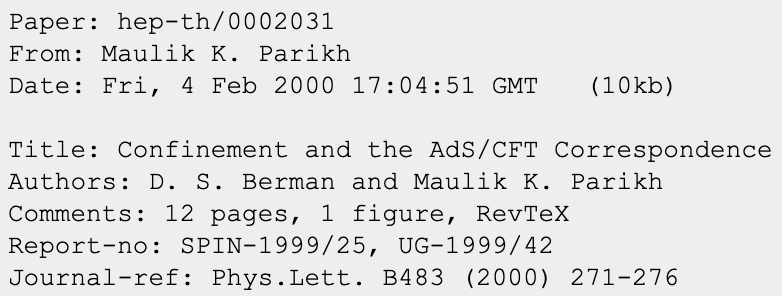

In [30]:
year_folders_path = "cit-HepTh-abstracts"  

# Process each year folder
for year_folder in os.listdir(year_folders_path):
    year_path = os.path.join(year_folders_path, year_folder)
    if not os.path.isdir(year_path):  
        continue

    # Process each .abs file in the year folder
    for abs_file in os.listdir(year_path):
        if abs_file.endswith(".abs"):
            node_id = int(abs_file.replace(".abs", ""))  
            abs_path = os.path.join(year_path, abs_file)

            
            with open(abs_path, "r") as file:
                metadata = file.read().strip()

            # Assigning the metadata to the node
            if node_id in graph:
                nx.set_node_attributes(graph, {node_id: {"metadata": metadata}})

# Saving the updated graph with metadata
updated_graph_path = "papers_graph_with_metadata.pkl"
with open(updated_graph_path, "wb") as f:
    pickle.dump(graph, f)

print(f"Metadata assigned to nodes and graph saved as '{updated_graph_path}'.")

Metadata assigned to nodes and graph saved as 'papers_graph_with_metadata.pkl'.


This plot visualizes a randomly sampled subgraph of 5000 nodes from the full network. The layout is generated using the ForceAtlas2.

100%|█████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 21.12it/s]


BarnesHut Approximation  took  6.33  seconds
Repulsion forces  took  7.37  seconds
Gravitational forces  took  0.05  seconds
Attraction forces  took  0.01  seconds
AdjustSpeedAndApplyForces step  took  0.25  seconds


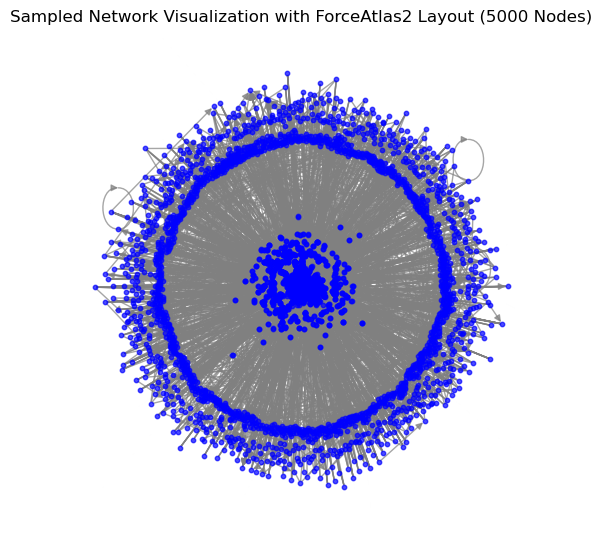

In [4]:
# Randomly choose 5000 nodes from the graph
sampled_nodes = random.sample(list(graph.nodes), 5000)

# Create a subgraph with the chosen nodes
subgraph = graph.subgraph(sampled_nodes)

forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=3.5,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=30.0,
    strongGravityMode=False,
    gravity=0.1,
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(subgraph, pos=None, iterations=300)

plt.figure(figsize=(5, 5))
nx.draw(
    subgraph,
    pos=positions,
    with_labels=False,  
    node_size=10,
    node_color="blue",
    edge_color="gray",
    alpha=0.7
)
plt.title("Sampled Network Visualization with ForceAtlas2 Layout (5000 Nodes)")
plt.show()

## Let's find some informations on our network

We will now compute key metrics to uncover meaningful insights about our network.

Number of Nodes: 27770
Number of Edges: 352807
Density: 0.0005
Average Clustering Coefficient: 0.1569
Average In-Degree: 12.70
Average Out-Degree: 12.70
Number of Strongly Connected Components: 20086
Number of Weakly Connected Components: 143


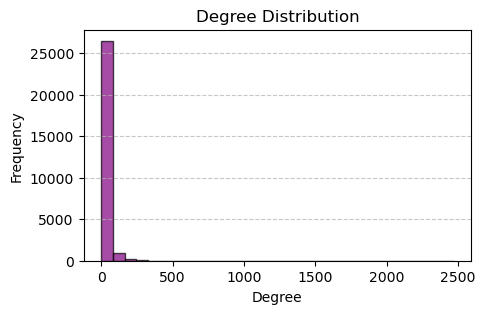

In [31]:
# Computing some metrics
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()
density = nx.density(graph)
avg_clustering = nx.average_clustering(graph)
avg_in_degree = sum(dict(graph.in_degree()).values()) / num_nodes
avg_out_degree = sum(dict(graph.out_degree()).values()) / num_nodes
num_scc = nx.number_strongly_connected_components(graph)
num_wcc = nx.number_weakly_connected_components(graph)

print(f"Number of Nodes: {num_nodes}")
print(f"Number of Edges: {num_edges}")
print(f"Density: {density:.4f}")
print(f"Average Clustering Coefficient: {avg_clustering:.4f}")
print(f"Average In-Degree: {avg_in_degree:.2f}")
print(f"Average Out-Degree: {avg_out_degree:.2f}")
print(f"Number of Strongly Connected Components: {num_scc}")
print(f"Number of Weakly Connected Components: {num_wcc}")

# Compute the degree (sum of in-degree and out-degree) for all nodes
degrees = [degree for node, degree in graph.degree()]

# Plot the degree distribution
plt.figure(figsize=(5, 3))
plt.hist(degrees, bins=30, color='purple', alpha=0.7, edgecolor='black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- The network density is very low. This shows that not all papers cite or are cited by others, we observe Sparse connectivity in the network.
- The average clustering coefficient is 0.1569. This indicates some local clustering, where groups of nodes (papers) are interconnected, potentially forming communities or subfields in the research domain.
- Both the average in-degree and out-degree are 12.7, which is expected because each edge represents a citation (outgoing from one node and incoming to another). This suggests that, on average, each paper cites or is cited by approximately 13 other papers.
- There are 143 weakly connected components, indicating the network has a relatively large connected subgraph and some smaller disconnected parts. This implies the presence of a core network and several peripheral papers that are not directly connected to the main cluster.


## Hub analysis

In this section, we analyze the in-degree of nodes in the citation network to identify the most influential papers, or hubs.

In [32]:
# In-degree for all nodes
in_degrees = dict(graph.in_degree())

# Sort nodes by in-degree in descending order
sorted_in_degrees = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)

# Keep the top 10 nodes representing the most cited papers
top_hubs = sorted_in_degrees[:10]

print("Top 10 Hubs (Highly Cited Papers):")
for node, in_degree in top_hubs:
    print(f"Node ID: {node}, In-Degree (Citations): {in_degree}")

Top 10 Hubs (Highly Cited Papers):
Node ID: 9711200, In-Degree (Citations): 2414
Node ID: 9802150, In-Degree (Citations): 1775
Node ID: 9802109, In-Degree (Citations): 1641
Node ID: 9407087, In-Degree (Citations): 1299
Node ID: 9610043, In-Degree (Citations): 1199
Node ID: 9510017, In-Degree (Citations): 1155
Node ID: 9908142, In-Degree (Citations): 1144
Node ID: 9503124, In-Degree (Citations): 1114
Node ID: 9906064, In-Degree (Citations): 1032
Node ID: 9408099, In-Degree (Citations): 1006


Let's see the metadata for the most cited paper

In [33]:
print("Most cited node Metadata:")
most_cited_node = 9711200
metadata = graph.nodes[most_cited_node].get("metadata", "No metadata available")
    
print(f"\nNode ID: {node}")
print(f"Metadata: {metadata}")  

Most cited node Metadata:

Node ID: 9408099
Metadata: ------------------------------------------------------------------------------
\\
Paper: hep-th/9711200
From: Juan Maldacena <malda@physics.rutgers.edu>
Date: Thu, 27 Nov 1997 23:53:13 GMT   (22kb)
Date (revised v2): Mon, 8 Dec 1997 18:59:11 GMT   (23kb)
Date (revised v3): Thu, 22 Jan 1998 15:42:41 GMT   (23kb)

Title: The Large N Limit of Superconformal Field Theories and Supergravity
Authors: Juan M. Maldacena
Comments: 20 pages, harvmac, v2: section on AdS_2 corrected, references added,
  v3: More references and a sign in eqns 2.8 and 2.9 corrected
Report-no: HUTP-98/A097
Journal-ref: Adv.Theor.Math.Phys. 2 (1998) 231-252; Int.J.Theor.Phys. 38 (1999)
  1113-1133
\\
  We show that the large $N$ limit of certain conformal field theories in
various dimensions include in their Hilbert space a sector describing
supergravity on the product of Anti-deSitter spacetimes, spheres and other
compact manifolds. This is shown by taking some br

The metadata suggests that **Juan M. Maldacena** is an influential figure in theoretical physics. We can guess that his work has likely shaped the field, as reflected in its high citation count.

## Community detection 

Now we will detect communities in our graph, for that we will use 2 techniques :

First we will use the **Louvain Algorithm** which optimizes communities detection to find the best communities, then we will find communities bases on the **creation date** of the papers. We will then compare both techniques by computing the modularity of both communities. 

In [37]:
graph_undirected = graph.to_undirected()

# Apply Louvain algorithm to detect communities
louvain_partition = community_louvain.best_partition(graph_undirected)

num_communities = len(set(louvain_partition.values()))
print(f"Number of communities detected: {num_communities}")

community_sizes = Counter(louvain_partition.values())

# Selecting the top 10 communities by size
top_communities = community_sizes.most_common(10)

print("Top 10 Largest Communities:")
for community, size in top_communities:
    print(f"Community {community}: {size} nodes")

# Visualization of communities 
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(graph_undirected, seed=42) 
nx.draw(
    graph_undirected,
    pos,
    node_color=[louvain_partition[node] for node in graph_undirected.nodes],
    node_size=10,
    cmap=plt.cm.tab20,
    with_labels=False,
    alpha=0.8
)
plt.title("Louvain Community Detection")
plt.show()

Number of communities detected: 171
Top 10 Largest Communities:
Community 1: 2573 nodes
Community 2: 2156 nodes
Community 4: 2084 nodes
Community 0: 1807 nodes
Community 13: 1789 nodes
Community 12: 1697 nodes
Community 9: 1686 nodes
Community 14: 1675 nodes
Community 6: 1513 nodes
Community 18: 1487 nodes


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

Now we detect communities based on the **creation date** :

In [34]:
# Method to extract the creation year from the "Date" field in the metadata
def extract_creation_year(metadata):
    match = re.search(r"Date: \w{3}, (\d{2}) \w{3} (\d{4})", metadata)
    if match:
        return match.group(2)  # Return the year 
    return None  # Return None if no match is found

# Grouping nodes by their creation year
communities_by_date = defaultdict(list)
for node in graph.nodes:
    metadata = graph.nodes[node].get("metadata", "")
    year = extract_creation_year(metadata)
    if year:
        communities_by_date[year].append(node)
    else:
        # Assign nodes without a creation year to a default community
        communities_by_date["Unknown"].append(node)

print(f"Number of communities detected by creation year: {len(communities_by_date)}")

for year, nodes in sorted(communities_by_date.items(), key=lambda x: x[0]):
    print(f"Year {year}: {len(nodes)} nodes")


Number of communities detected by creation year: 13
Year 1992: 179 nodes
Year 1993: 437 nodes
Year 1994: 795 nodes
Year 1995: 1101 nodes
Year 1996: 1425 nodes
Year 1997: 1678 nodes
Year 1998: 1875 nodes
Year 1999: 1950 nodes
Year 2000: 2244 nodes
Year 2001: 2231 nodes
Year 2002: 2323 nodes
Year 2003: 710 nodes
Year Unknown: 10822 nodes


To better understand the found communities, let's compute the **confusion matrix** of the Dates vs Louvain Communities:

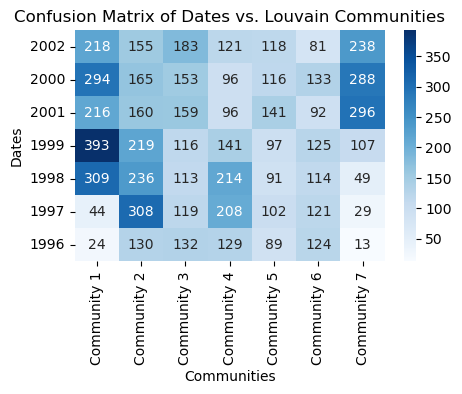

In [35]:
# Extract creation years for all nodes
node_years = {}
for node in graph.nodes:
    metadata = graph.nodes[node].get("metadata", "")
    year = extract_creation_year(metadata)
    if year:
        node_years[node] = year

# Selecting the 7 most common years
all_years = list(node_years.values())
year_counts = Counter(all_years)
top_years = [year for year, _ in year_counts.most_common(7)]

# Grouping the nodes by community
community_nodes = defaultdict(list)
for node, community_id in louvain_partition.items():
    community_nodes[community_id].append(node)

# Sorting communities by size and select the top 7 communities
sorted_communities = sorted(community_nodes.items(), key=lambda x: len(x[1]), reverse=True)
top_communities = [community_id for community_id, nodes in sorted_communities[:7]]

# Building the confusion matrix
confusion_matrix = np.zeros((7, 7), dtype=int)

# Mapping years and communities to indices for the matrix
year_index = {year: idx for idx, year in enumerate(top_years)}
community_index = {community_id: idx for idx, community_id in enumerate(top_communities)}

# Populating the confusion matrix
for node, community_id in louvain_partition.items():
    if community_id in top_communities and node in node_years:
        community_idx = community_index[community_id]
        year = node_years[node]
        if year in top_years:
            year_idx = year_index[year]
            confusion_matrix[year_idx, community_idx] += 1

confusion_df = pd.DataFrame(confusion_matrix, index=top_years, columns=[f'Community {i+1}' for i in range(7)])

# Plot the confusion matrix with seaborn 
plt.figure(figsize=(5, 3))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of Dates vs. Louvain Communities")
plt.xlabel("Communities")
plt.ylabel("Dates")
plt.show()

The confusion matrix shows the relationship between creation dates (rows) and Louvain communities (columns).We notice that nodes from the same year are spread across multiple communities. This indicates that Louvain communities are shaped more by citation structures than by the creation date. To confirm, we can compute the modularity for each partition we found :

In [38]:
# Calculating modularity for the Louvain partition
modularity_louvain = community_louvain.modularity(louvain_partition, graph_undirected)
print("Modularity of the partition using Louvain Algorithm: " + str(modularity_louvain))

# Convert communities_by_date to a list of sets
community_list = [set(nodes) for nodes in communities_by_date.values()]

# Calculating modularity for the date-based partition
modularity_date = nx.algorithms.community.modularity(graph, community_list)

print("Modularity of the network partitioned by creation dates: " + str(modularity_date))

Modularity of the partition using Louvain Algorithm: 0.6577367240897095
Modularity of the network partitioned by creation dates: 0.0691253028647155


### Comparison and Interpretation

The modularity using the Louvain algorithm is **much higher** than the modularity for creation date partitions. This suggests that Louvain detects cohesive communities based on network structure, while grouping by creation dates does not align well with the network’s organization.

Initially, we might expect papers from the same year to cite each other more frequently, as research fields evolve and build on recent findings. However, the low modularity for creation date partitions suggests this is not necessarily the case, indicating that citations often span across years and do not strictly depend on time.

## Text Analysis

Each paper in the dataset contains a **descriptive text** in its metadata, providing an overview of its content. For our analysis, we will compute a complexity score for the descriptive text of each paper. We will then investigate whether more complex language correlates with a higher number of citations, helping us understand the relationship between language complexity and a paper’s impact.

Let's quickly check that we indeed have a descriptive text for all papers :

In [39]:
# Function to check if a descriptive text is present in the metadata
def has_descriptive_text(metadata):
    parts = metadata.split('\\\\')
    if len(parts) > 2:  # Ensure there is a third part
        descriptive_text = parts[2].strip()  # Extract the text after the second '\\'
        return len(descriptive_text) > 0  # Check if it contains any text
    return False

papers_with_description = 0
total_papers = 0

for node in graph.nodes:
    metadata = graph.nodes[node].get("metadata", "")
    total_papers += 1
    if has_descriptive_text(metadata):
        papers_with_description += 1

print(f"Total papers: {total_papers}")
print(f"Papers with descriptive text: {papers_with_description}")
print(f"Percentage with descriptive text: {papers_with_description / total_papers * 100:.2f}%")

Total papers: 27770
Papers with descriptive text: 27770
Percentage with descriptive text: 100.00%


We are now sure that all papers have a descriptive text. 

We will use the **Flesch Reading Ease score** which is a metric used to evaluate the readability of a text. It is calculated based on the average sentence length and the average number of syllables per word in the text. The score ranges from 0 to 100, where:
- Higher Scores: Indicate simpler, easier-to-read text.
- Lower Scores: Indicate more complex text.

For this analysis, the Flesch Reading Ease score is computed for the descriptive text of each paper, and we investigate whether more complex texts (lower scores) correlate with higher citation counts.

More information here : https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests

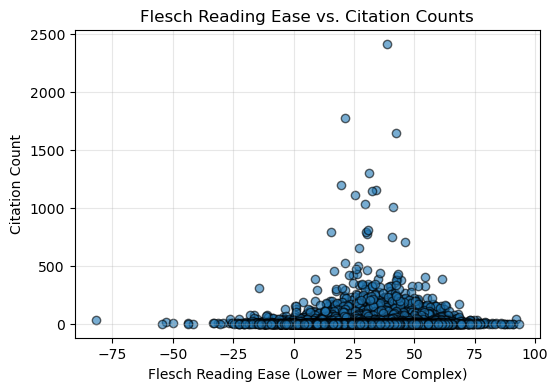

Sample Readability Scores and Citation Counts:
Readability: 46.06, Citations: 10
Readability: 28.20, Citations: 16
Readability: 36.59, Citations: 115
Readability: 28.67, Citations: 140
Readability: 38.66, Citations: 55
Readability: 24.78, Citations: 421
Readability: 28.17, Citations: 77
Readability: 31.21, Citations: 1299
Readability: 41.29, Citations: 1006
Readability: 24.98, Citations: 126


In [45]:
# Compute citation counts (in-degree of each node)
citation_counts = {node: graph.in_degree(node) for node in graph.nodes}

# Prepare data for plotting
readability = []
citations = []
for node, score in readability_scores.items():
    if node in citation_counts:  # Ensure both readability and citations exist for the node
        readability.append(score)
        citations.append(citation_counts[node])

# Check if data is available
if not readability or not citations:
    print("No data available for plotting. Ensure readability_scores and citation counts are computed.")
else:
    # Scatter plot
    plt.figure(figsize=(6, 4))
    plt.scatter(readability, citations, alpha=0.6, edgecolor="k")
    plt.title("Flesch Reading Ease vs. Citation Counts")
    plt.xlabel("Flesch Reading Ease (Lower = More Complex)")
    plt.ylabel("Citation Count")
    plt.grid(alpha=0.3)
    plt.show()

# Print sample results for verification
print("Sample Readability Scores and Citation Counts:")
for i in range(min(10, len(readability))):
    print(f"Readability: {readability[i]:.2f}, Citations: {citations[i]}")

As we notice here, in some cases, the Flesch Reading Ease score can be negative, which occurs when the text is extremely complex, characterized by very long sentences and a high number of multi-syllable words. We found that negative scores are common for academic papers or highly technical texts, as they make them significantly harder to read. We decided to retain these negative values as they provide meaningful insights into the complexity of the text.

- Most papers fall in the 0 to 50 range, indicating high complexity typical of academic texts.
- Some **highly complex papers** (negative scores) have very low citation counts, possibly because their complexity makes them less accessible and harder to understand.
- Papers with scores **between 20 and 40** tend to have higher citation counts, suggesting that texts with moderate complexity are easier to read while still being detailed enough to attract citations.

This indicates that complexity is not always correlated with citations, as **accessibility** may play a role in a paper’s impact. 

We can suggest based on our findings that a **balance between readability and complexity** might contribute to a paper’s success, as it makes the work both relevant and accessible to a broader audience.